##Importing required libraries and data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/Mumbai_house_rent_99acers/Mumbai_99acers_cleaned.csv')
logdf = pd.read_csv('/content/drive/MyDrive/Datasets/Mumbai_house_rent_99acers/Mumbai_99acers_logtransformed.csv')

In [3]:
logdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12797 entries, 0 to 12796
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   society        12797 non-null  object 
 1   type           12797 non-null  object 
 2   location       12797 non-null  object 
 3   bedrooms       12797 non-null  int64  
 4   built-up area  12797 non-null  float64
 5   furnishing     12797 non-null  object 
 6   age            12797 non-null  object 
 7   floor          12797 non-null  int64  
 8   total floors   12797 non-null  int64  
 9   monthly rent   12797 non-null  float64
dtypes: float64(2), int64(3), object(5)
memory usage: 999.9+ KB


In [4]:
df['area-per-bedroom'] = df['built-up area']/df['bedrooms']

In [5]:
logdf['area-per-bedroom'] = logdf['built-up area']/logdf['bedrooms']
logdf.head()

,society,type,location,bedrooms,built-up area,furnishing,age,floor,total floors,monthly rent,area-per-bedroom
0,other society,Residential Apartment,Bandra (West),2,800.0,Furnished,5 to 10 years old,2,6,11.350407,400.000000
1,other society,Residential Apartment,Khar West,2,1050.0,Furnished,1 to 5 years old,8,12,11.608236,525.000000
2,Gajra Bhoomi Symphony,Residential Apartment,Sector-20 Koparkhairane,2,1050.0,Unfurnished,1 to 5 years old,14,17,10.373491,525.000000
3,Crescent Bay,Residential Apartment,Parel,3,2275.0,Semifurnished,1 to 5 years old,40,41,11.918391,758.333333
4,Ashwini CHS,Residential Apartment,Tilak Nagar,1,550.0,Semifurnished,5 to 10 years old,4,7,10.203592,550.000000


## OneHotEncoding Text features

In [6]:
temp = pd.get_dummies(df, drop_first=True)
corr = temp.corr()['monthly rent'].sort_values()

In [7]:
logtemp = pd.get_dummies(logdf, drop_first=True)
logcorr = logtemp.corr()['monthly rent'].sort_values()

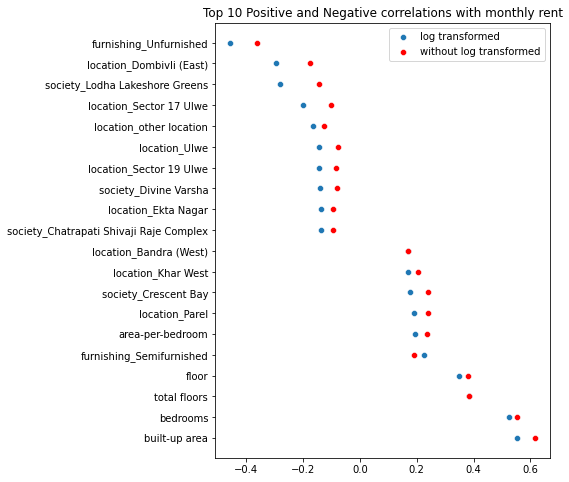

In [8]:
plt.figure(figsize=(6,8))

sns.scatterplot(y= logcorr.head(10).index.append(logcorr.tail(11)[:-1].index), 
                x= list(logcorr.head(10).values) + list(logcorr.tail(11)[:-1].values), label='log transformed')
sns.scatterplot(y= logcorr.head(10).index.append(logcorr.tail(11)[:-1].index), 
                x= corr[logcorr.head(10).index.append(logcorr.tail(11)[:-1].index)].values, color='red', label='without log transformed')
plt.title('Top 10 Positive and Negative correlations with monthly rent')
plt.legend()
plt.show()

## Preparing Training and Testing Datasets

In [9]:
x = temp.drop('monthly rent', axis = 1)
y = temp['monthly rent']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10237, 356), (2560, 356), (10237,), (2560,))

In [10]:
logx = logtemp.drop('monthly rent', axis = 1)
logy = logtemp['monthly rent']

logx_train, logx_test, logy_train, logy_test = train_test_split(logx, logy, test_size=0.2, random_state=42)
logx_train.shape, logx_test.shape, logy_train.shape, logy_test.shape

((10237, 356), (2560, 356), (10237,), (2560,))

## Scaling Datasets to convert them into same range.

In [11]:
linear = Pipeline([('scaler', StandardScaler()),
                   ('model', LinearRegression())])

In [12]:
linear.fit(X_train, y_train)
print('r2 score:',r2_score(y_test, linear.predict(X_test)))
print('rmse:',mean_squared_error(y_test, linear.predict(X_test))**.5)

r2 score: 0.8850249399852936
rmse: 12192.737654367309


In [13]:
linear.fit(logx_train,logy_train)
print('r2 score:',r2_score(logy_test, linear.predict(logx_test)))
print('rmse:',mean_squared_error(logy_test, linear.predict(logx_test))**.5)

r2 score: 0.9275648684792374
rmse: 0.19852773815105582


**Clearly log transformed help to improve score**

## Linear models

In [14]:
Final_Scores = pd.DataFrame( index = ['With Training Data r2 score','With Test Data r2 score',
                                       'With Training Data rmse', 'With Test Data rmse'])

models = [LinearRegression(), Ridge(), Lasso()]
names = ['LinearRegression', 'Ridge', 'Lasso']

for name,model in zip(names,models):

  pipeline = Pipeline([('scaler', StandardScaler()),
                    (name, model)])
  
  pipeline.fit(logx_train,logy_train)

  Final_Scores[name] = [round(r2_score(logy_train, pipeline.predict(logx_train)), 4), 
                         round(r2_score(logy_test, pipeline.predict(logx_test)), 4),
                         round(mean_squared_error(logy_train, pipeline.predict(logx_train))**.5, 4),
                         round(mean_squared_error(logy_test, pipeline.predict(logx_test))**.5, 4)]
else:
  display(Final_Scores)

,LinearRegression,Ridge,Lasso
With Training Data r2 score,0.9210,0.9209,0.0000
With Test Data r2 score,0.9276,0.9276,-0.0001
With Training Data rmse,0.2071,0.2071,0.7365
With Test Data rmse,0.1985,0.1985,0.7377


In [32]:
param_grid = {'alpha':[.0001,.001, .01, .1, 1, 10, 100]}

model = GridSearchCV(Ridge(), param_grid, cv=5)
model.fit(logx_train,logy_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [33]:
model.best_params_, model.best_score_

({'alpha': 0.001}, 0.9170490887456196)

In [34]:
print('r2 score:',r2_score(logy_test, model.predict(logx_test)))
print('rmse:',mean_squared_error(logy_test, model.predict(logx_test))**.5)

r2 score: 0.9275667338831004
rmse: 0.19852518181695236


# Tree based models using One Hot Encoding

In [18]:
models = [DecisionTreeRegressor(), RandomForestRegressor(), XGBRegressor(), GradientBoostingRegressor()]
names = ['DecisionTreeRegressorOHE', 'RandomForestRegressorOHE', 'XGBRegressorOHE', 'GradientBoostingRegressorOHE']

for name,model in zip(names,models):

  model.fit(logx_train,logy_train)

  Final_Scores[name] = [round(r2_score(logy_train, pipeline.predict(logx_train)), 4), 
                         round(r2_score(logy_test, pipeline.predict(logx_test)), 4),
                         round(mean_squared_error(logy_train, pipeline.predict(logx_train))**.5, 4),
                         round(mean_squared_error(logy_test, pipeline.predict(logx_test))**.5, 4)]
else:
  display(Final_Scores)

[18:58:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,LinearRegression,Ridge,Lasso,DecisionTreeRegressorOHE,RandomForestRegressorOHE,XGBRegressorOHE,GradientBoostingRegressorOHE
With Training Data r2 score,0.9210,0.9209,0.0000,0.0000,0.0000,0.0000,0.0000
With Test Data r2 score,0.9276,0.9276,-0.0001,-0.0001,-0.0001,-0.0001,-0.0001
With Training Data rmse,0.2071,0.2071,0.7365,0.7365,0.7365,0.7365,0.7365
With Test Data rmse,0.1985,0.1985,0.7377,0.7377,0.7377,0.7377,0.7377


As expected they can't work with OHE

## LabelEncoder

In [19]:
df1 = logdf.copy()
df1.head(3)

,society,type,location,bedrooms,built-up area,furnishing,age,floor,total floors,monthly rent,area-per-bedroom
0,other society,Residential Apartment,Bandra (West),2,800.0,Furnished,5 to 10 years old,2,6,11.350407,400.0
1,other society,Residential Apartment,Khar West,2,1050.0,Furnished,1 to 5 years old,8,12,11.608236,525.0
2,Gajra Bhoomi Symphony,Residential Apartment,Sector-20 Koparkhairane,2,1050.0,Unfurnished,1 to 5 years old,14,17,10.373491,525.0


In [20]:
society_encoder = LabelEncoder().fit(df1['society'])
df1['society'] = society_encoder.transform(df1['society'])

type_encoder = LabelEncoder().fit(df1['type'])
df1['type'] = type_encoder.transform(df1['type'])

furnishing_encoder = LabelEncoder().fit(df1['furnishing'])
df1['furnishing'] = furnishing_encoder.transform(df1['furnishing'])

location_encoder = LabelEncoder().fit(df1['location'])
df1['location'] = location_encoder.transform(df1['location'])

age_encoder = LabelEncoder().fit(df1['age'])
df1['age'] = age_encoder.transform(df1['age'])

In [21]:
df1

,society,type,location,bedrooms,built-up area,furnishing,age,floor,total floors,monthly rent,area-per-bedroom
0,176,1,8,2,800.0,0,3,2,6,11.350407,400.000000
1,176,1,63,2,1050.0,0,1,8,12,11.608236,525.000000
2,36,1,128,2,1050.0,3,1,14,17,10.373491,525.000000
3,20,1,88,3,2275.0,2,1,40,41,11.918391,758.333333
4,8,1,150,1,550.0,2,3,4,7,10.203592,550.000000
...,...,...,...,...,...,...,...,...,...,...,...
12792,176,1,94,3,2529.0,0,1,12,32,12.072541,843.000000
12793,150,1,83,3,1382.0,2,0,27,40,10.778956,460.666667
12794,176,1,165,3,1750.0,3,2,9,16,12.206073,583.333333
12795,176,1,109,2,950.0,2,3,8,10,10.146434,475.000000


## Tree based models

In [22]:
x_train, x_test, y_train, y_test = train_test_split(df1.drop('monthly rent', axis = 1), df1['monthly rent'], test_size=0.2, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape 

((10237, 10), (2560, 10), (10237,), (2560,))

In [23]:
models = [DecisionTreeRegressor(), RandomForestRegressor(), XGBRegressor(), GradientBoostingRegressor()]
names = ['DecisionTreeRegressorLE', 'RandomForestRegressorLE', 'XGBRegressorLE', 'GradientBoostingRegressorLE']

for name,model in zip(names,models):

  model.fit(x_train,y_train)

  Final_Scores[name] = [round(r2_score(y_train, model.predict(x_train)), 4), 
                         round(r2_score(y_test, model.predict(x_test)), 4),
                         round(mean_squared_error(y_train, model.predict(x_train))**.5, 4),
                         round(mean_squared_error(y_test, model.predict(x_test))**.5, 4)]
else:
  display(Final_Scores)

[18:58:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,LinearRegression,Ridge,Lasso,DecisionTreeRegressorOHE,RandomForestRegressorOHE,XGBRegressorOHE,GradientBoostingRegressorOHE,DecisionTreeRegressorLE,RandomForestRegressorLE,XGBRegressorLE,GradientBoostingRegressorLE
With Training Data r2 score,0.9210,0.9209,0.0000,0.0000,0.0000,0.0000,0.0000,0.9988,0.9779,0.8047,0.8064
With Test Data r2 score,0.9276,0.9276,-0.0001,-0.0001,-0.0001,-0.0001,-0.0001,0.7221,0.8536,0.7959,0.7986
With Training Data rmse,0.2071,0.2071,0.7365,0.7365,0.7365,0.7365,0.7365,0.0251,0.1095,0.3255,0.3241
With Test Data rmse,0.1985,0.1985,0.7377,0.7377,0.7377,0.7377,0.7377,0.3888,0.2822,0.3332,0.3310


##Decisiontree gridsearch

In [24]:
param_grid = {'max_depth':[3,4,5,6,7,10,15,20],
              'min_samples_leaf':[2,3,4,5,6]}

model = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5)
model.fit(x_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 10, 15, 20],
                         'min_samples_leaf': [2, 3, 4, 5, 6]},
             pre_dispatch

In [25]:
model.best_params_, model.best_score_

({'max_depth': 15, 'min_samples_leaf': 6}, 0.7482444408521531)

In [26]:
round(mean_squared_error(y_train, model.predict(x_train))**.5, 4)

0.2478

In [27]:
round(mean_squared_error(y_test, model.predict(x_test))**.5, 4)

0.3509

##RandomForest gridsearch

In [28]:
param_grid = {'n_estimators':[50,100,150,200],
              'max_depth':[3,4,5,6,7,10,15,20],
              'min_samples_leaf':[2,3,4,5,6]}

model = RandomizedSearchCV(RandomForestRegressor(), param_grid, cv=5)
model.fit(x_train,y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [29]:
model.best_params_, model.best_score_

({'max_depth': 15, 'min_samples_leaf': 6, 'n_estimators': 100},
 0.8157228142491405)

In [30]:
round(mean_squared_error(y_train, model.predict(x_train))**.5, 4)

0.2368

In [31]:
round(mean_squared_error(y_test, model.predict(x_test))**.5, 4)

0.3084

##XGBRegressor gridsearch

In [36]:
parameters = {'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07],
              'max_depth': [5, 6, 7, 8],
              'n_estimators': [200,300,400,500]}

model = RandomizedSearchCV(XGBRegressor(), parameters, cv = 5)
model.fit(x_train,y_train)

[19:09:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:09:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:09:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:09:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:09:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:09:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:09:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:09:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=0,
                                          reg_lambda=1, scale_pos_weight=1,
                                          seed=None, silent=None, subsample=1,
                                  

In [37]:
model.best_params_, model.best_score_

({'learning_rate': 0.07,
  'max_depth': 6,
  'n_estimators': 500,
  'objective': 'reg:linear'},
 0.9150054694964519)

In [38]:
round(mean_squared_error(y_train, model.predict(x_train))**.5, 4)

0.1242

In [39]:
round(mean_squared_error(y_test, model.predict(x_test))**.5, 4)

0.1958

In [55]:
x_train.iloc[[0,]], y_train.iloc[0]

(      society  type  location  ...  floor  total floors  area-per-bedroom
 3781       93     1        29  ...     18            19             459.0
 
 [1 rows x 10 columns], 9.546812608597397)

In [57]:
model.predict(x_train.iloc[[0,]]), y_train.iloc[0]

(array([9.554807], dtype=float32), 9.546812608597397)

In [58]:
np.exp(9.554807), np.exp(9.546812608597397)

(14112.370046235981, 14000.000000000025)

Linear Regression and XGBoost with parameter tuning perform comparable.

# Winner is **Linear Regression and XGBoost Regressor** with rmse of .19:)